# Coarsening induced by Gaussian Process prior

In this notebook I compute the KL between a diagonal posterior and a Multivariate Normal Prior with correlation. The KL term between posterior and prior induces coarsening till the lenght scale of the prior. 
The application is to regularize the heat MAP (latent variable). Note that this is NOT the usual regression application of GP since I never observe any value. 
Finally note that I assume GP is from R^N -> R

# KL MULTIVARIATE GAUSSIAN 

The prior is a multivariate Gaussian (GP). 
The covariance matrix is decomposed only once (at the beginning) as cov1 = L1 L1^T by cholesky decomposition
The posterior is a DIAGONAL Normal distribution, therefore cov0 = L0 L0^T = diagonal means that L0 = diag(sigma) 
can be compute at each iteration very cheaply. I have simple analytical expression for the KL_divergence of two multivariate gaussian in terms of mu0, L0, mu1, L1 
Therefore I can frame everyting in the usual VAE framework with KL(posterio|prior) + RECONSTRUCTION

Implement the KL between two distribution for the special case of posterior (i.e. N0) being diagonal and prior (i.e. N1) being a GP which means that the covariance cna be calculated using the Kernel
<img src="KL_multivariate_gaussian.png">

### The main observation is that a diagonal posterior can minimize the KL with a GP prior by: 1. using correlated mu, 2. sending sigma to small values. Altough the sample from the prior and optimized posterior can look identical the KL between the two distribution can never be zero b/c they belong to different classes.

### IMPORT NECESSARY MODULES

In [75]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
import moviepy.editor as mpy
from IPython.core.display import display, HTML, Image
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d, Axes3D 

import os, glob
from functools import partial
import torch
import torch.nn.functional as F
from torch.distributions import MultivariateNormal, Normal
import numpy as np
from torchvision import utils
from typing import Optional
from collections import namedtuple 

def show_batch(images: torch.Tensor,
               n_col: int = 4,
               n_padding: int = 10,
               title: Optional[str] = None,
               pad_value: int = 1):
    """Visualize a torch tensor of shape: (batch x ch x width x height) """
    assert len(images.shape) == 4  # batch, ch, width, height
    if images.device != "cpu":
        images = images.cpu()
    grid = utils.make_grid(images, n_col, n_padding, normalize=True, range=(0.0, 1.0),
                           scale_each=False, pad_value=pad_value)
        
    fig = plt.figure()
    plt.imshow(grid.detach().numpy().transpose((1, 2, 0)))
    if isinstance(title, str):
        plt.title(title)
    plt.close(fig)
    fig.tight_layout()
    return fig

def are_boradcastable(a: torch.Tensor, b: torch.Tensor) -> bool:
    return all((m == n) or (m == 1) or (n == 1) for m, n in zip(a.shape[::-1], b.shape[::-1]))

# Example of plotting 3D surfaces

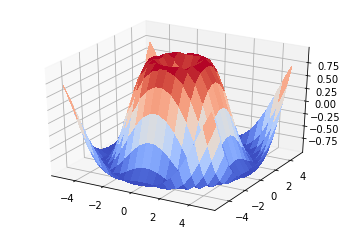

In [77]:
xv, yv = torch.meshgrid([torch.linspace(-5.0,5.0,20), torch.linspace(-5.0,5.0,20)])
zv = torch.sin(torch.sqrt(xv**2 + yv**2))

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xv.numpy(), yv.numpy(), zv.numpy(), cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.show()

# Helper function to draw GP

In [78]:
def make_mesh_grid(x_array: torch.Tensor, y_array: torch.Tensor):
    if torch.cuda.is_available():
        x_array = x_array.cuda()
        y_array = y_array.cuda()
    xv, yv = torch.meshgrid([x_array, y_array])
    points = torch.stack((xv, yv ), dim=-1).view(1,-1,2)  # shape: (batch=1, n, 2)
    return namedtuple("grid","xv yv points")._make([xv, yv, points])

def zero_mean(points):
    """ Input: points.shape = (*, n, D) 
        Output: mu.shape =  (*, n)  
        where batched_dimension * might or might not be present
    """
    independet_dim = points.shape[:-1]
    return torch.zeros(independet_dim, dtype=points.dtype, device=points.device)

def squared_exponential_kernel(points1, points2, length_scale, eps=1E-3):
    """ Input:
        points1.shape = (*, n, D)
        points2.shape = (*, m, D)
        Output: 
        C.shape = (*, n, m)
        where batched_dimension * might or might not be present
        It is necessary to add small positive shift on the diagonal otherwise Cholesky decomposition fails
    """
    dim1 = points1.shape[-1]
    dim2 = points2.shape[-1]
    assert dim1 == dim2
    points1 = points1.unsqueeze(-2)/length_scale  # *, n, 1, D
    points2 = points2.unsqueeze(-3)/length_scale # *, 1, m, D
    scaled_d2 = (points1-points2).pow(2).sum(dim=-1) # *, n, m
    cov = torch.exp(-0.5 * scaled_d2)  # this covariance is between (0,1)
    
    # add STRICTLY POSITIVE noise on the diagonal to prevent matrix from becoming close to singular    
    diag_shift = eps * torch.ones_like(cov[...,0]) 
    return (cov + torch.diag_embed(diag_shift, dim1=-2, dim2=-1)).clamp(min=0)

    
def draw_from_GP(points, mean_func, conv_func):
    loc = mean_func(points)
    cov = conv_func(points,points)
    # print("loc ->",loc.shape)  # (*, n)
    # print("cov ->",cov.shape)  # (*, n, n)
    z = MultivariateNormal(loc=loc, covariance_matrix=cov).sample()
    assert z.shape == loc.shape
    return z

# Test
N = 45
grid = make_mesh_grid(x_array=torch.arange(0,N).float(),
                      y_array=torch.arange(0,N).float())

cov = squared_exponential_kernel(grid.points, grid.points, length_scale=4.36, eps=1E-3)

L = torch.cholesky(cov)
print("cholesky ->",torch.max(torch.abs(cov - torch.torch.matmul(L,L.transpose(dim0=-2,dim1=-1)))))

cholesky -> tensor(8.9407e-07, device='cuda:0')


# Helper function to compute KL between multivariate Normal

In [79]:
def logp_multivariate_vs_collection_univariate(value, mu0, L_cov0, mu1, L_cov1):
    """ Input: value = (*, n) 
               mu0, mu1 = (*, n)
               L_cov0, L_cov1 = (*, n, n)
        Output: KL = (*) 
    """  
    sigma0 = torch.diagonal(L_cov0, dim1=-1, dim2=-2, offset=0)

    log0_multivariate = MultivariateNormal(loc=mu0, scale_tril=L_cov0).log_prob(value)
    log0_univariate = Normal(loc=mu0, scale=sigma0).log_prob(value).sum(dim=-1)
    log1_multivariate = MultivariateNormal(loc=mu1, scale_tril=L_cov1).log_prob(value)
    
    assert log0_multivariate.shape == log0_univariate.shape == log1_multivariate.shape
    return log0_multivariate, log0_univariate, log1_multivariate

def KL_multivariate_numerical(value, mu0, mu1, L_cov0, L_cov1):
    """ Input: value = (*, n) 
               mu0, mu1 = (*, n)
               L_cov0, L_cov1 = (*, n, n)
        Output: KL = (*) 
    """  
    log0 = MultivariateNormal(loc=mu0, scale_tril=L_cov0).log_prob(value)
    log1 = MultivariateNormal(loc=mu1, scale_tril=L_cov1).log_prob(value)
    return log0-log1

def KL_multivariate_numerical_average(Nav: int, 
                                      mu0: torch.Tensor,
                                      mu1: torch.Tensor, 
                                      L_cov0: torch.Tensor, 
                                      L_cov1: torch.Tensor):
    d = MultivariateNormal(loc=mu0, scale_tril=L_cov0)
    kl_av = 0
    for n in range(Nav):    
        value = d.rsample()    
        kl=KL_multivariate_numerical(value, mu0, mu1, L_cov0, L_cov1)    
        kl_av += kl
    return kl_av/Nav

def KL_multivariate_analytical_stupid(mu0: torch.Tensor,
                                      mu1: torch.Tensor,
                                      cov0: torch.Tensor,
                                      cov1: torch.Tensor):
    """ Input: mu0, mu1 = (*, n)
               cov0, cov1 = (*, n, n)
        Output: KL = (*) 
    """
    assert are_boradcastable(mu0, mu1)  # (*, n)
    assert are_boradcastable(cov0, cov1) # (*, n, n) 
    n = cov0.shape[-1]
    
    cov1_inverse = torch.inverse(cov1)  # (*, n, n)
    prod = torch.matmul(cov1_inverse,cov0) # (*, n, n)
    diag = torch.diagonal(prod,dim1=-1,dim2=-2) # (*, n)
    trace_term = diag.sum(dim=-1)  # (*)
    #print("trace_term",trace_term.shape, trace_term)
    
    x = (mu1-mu0)  # (*, n)
    M_tmp = torch.matmul(cov1_inverse, x.unsqueeze(-1)) # (*, n, 1) = (*, n, n) (*, n, 1)
    square_term = torch.matmul(x.unsqueeze(-2), M_tmp)[...,0,0]  #  (*, 1, 1) = (*, 1, n) (*, n, 1) 
    #print("square_term",square_term.shape, square_term)
    
    logdet_term = torch.logdet(cov1) - torch.logdet(cov0) # (x)
    #print("logdet_term",logdet_term.shape, logdet_term)
    
    return 0.5*(trace_term + square_term - n + logdet_term)

def KL_multivariate_analytical_smart(mu0: torch.Tensor,
                                     mu1: torch.Tensor,
                                     L_cov0: torch.Tensor,
                                     L_cov1: torch.Tensor):
    assert are_boradcastable(mu0, mu1)  # (*, n)
    assert are_boradcastable(L_cov0, L_cov1)  # (*, n, n) 
    n = L_cov0.shape[-1]
    
    # Tr[cov1^(-1)cov0] = Tr[L L^T] = sum_of_element_wise_square(L) 
    # where L = L1^(-1) L0 -> Solve trilinear problem: L1 L = L0
    L = torch.triangular_solve(L_cov0, A=L_cov1, upper=False, transpose=False, unitriangular=False)[0]  # (*,n,n)
    trace_term = torch.sum(L.pow(2), dim=(-1,-2))  # (*)
    #print("trace_term",trace_term.shape, trace_term)
    
    # x^T conv1^(-1) x = z^T z where z = L1^(-1) x -> solve trilinear problem L1 z = x 
    dmu = (mu0-mu1).unsqueeze(-1)  # (*,n,1)
    z = torch.triangular_solve(dmu, A=L_cov1, upper=False, transpose=False, unitriangular=False)[0]  # (*,n,1)
    # Now z.t*z is the sum over both n_points and dimension
    square_term = z.pow(2).sum(dim=(-1,-2))  # (*)
    #print("square_term",square_term.shape, square_term)
    
    # log[det(cov)]= log[det(L L^T)] = logdet(L) + logdet(L^T) = 2 logdet(L)
    # where logdet casn be computed as the sum of the diagonal elements
    logdet1 = torch.diagonal(L_cov1,dim1=-1,dim2=-2).log().sum(-1)
    logdet0 = torch.diagonal(L_cov0,dim1=-1,dim2=-2).log().sum(-1)
    logdet_term = 2 * (logdet1 - logdet0) # (*)  factor of 2 b/c log[det(L L^T)]= 2 log[det(L)]
    #print("logdet_term",logdet_term.shape, logdet_term)
    
    return 0.5*(trace_term + square_term - n + logdet_term)

# Test

In [80]:
grid = make_mesh_grid(x_array=torch.arange(0,20).float(),
                      y_array=torch.arange(0,20).float())
    
k = grid.points.shape[-1]
mu1 = zero_mean(grid.points)
mu0 = torch.randn_like(mu1)
cov1 = squared_exponential_kernel(grid.points, grid.points, length_scale=2.0, eps=1E-3)
sigma0 = F.softplus(torch.randn_like(mu1))
L_cov0 = torch.diag_embed(sigma0, dim1=-2, dim2=-1)
cov0 = torch.diag_embed(sigma0.pow(2), dim1=-2, dim2=-1)
L_cov1=torch.cholesky(cov1)

print("check ->",(torch.cholesky(cov0) - L_cov0).abs().max())

# real calculation
print(KL_multivariate_analytical_stupid(mu0=mu0, mu1=mu1, cov0=cov0, cov1=cov1))
print(KL_multivariate_analytical_smart(mu0=mu0, mu1=mu1, L_cov0=L_cov0, L_cov1=L_cov1))
#print(KL_multivariate_numerical_average(Nav=1000, mu0=mu0, mu1=mu1, L_cov0=L_cov0, L_cov1=L_cov1))

value = Normal(loc=mu0, scale=sigma0).sample()
print(logp_multivariate_vs_collection_univariate(value, mu0=mu0, L_cov0=L_cov0, mu1=mu1, L_cov1=L_cov1))
    

# sanity check
print("--------------------")
print(KL_multivariate_analytical_smart(mu0=mu1, mu1=mu1, L_cov0=L_cov1, L_cov1=L_cov1))
print(KL_multivariate_analytical_smart(mu0=mu0, mu1=mu0, L_cov0=L_cov0, L_cov1=L_cov0))

check -> tensor(2.3842e-07, device='cuda:0')
tensor([199893.4844], device='cuda:0')
tensor([199886.7031], device='cuda:0')
(tensor([-384.3414], device='cuda:0'), tensor([-384.3414], device='cuda:0'), tensor([-200456.5469], device='cuda:0'))
--------------------
tensor([0.], device='cuda:0')
tensor([0.], device='cuda:0')


# TRAIN UNDER KL

mu1 ---> torch.Size([1, 400]) cuda:0
cov1 ---> torch.Size([1, 400, 400]) cuda:0
zprior -> torch.Size([8, 400]) cuda:0
tensor([316.8969, 332.5382, 323.8881, 302.4610, 337.4886, 341.5013, 337.3266,
        320.0308], device='cuda:0') tensor([830.7175, 830.7175, 830.7175, 830.7175, 830.7175, 830.7175, 830.7175,
        830.7175], device='cuda:0') tensor([-581.8606, -485.2267, -583.1922, -576.8190, -533.2596, -502.7931,
        -573.6001, -524.9135], device='cuda:0')


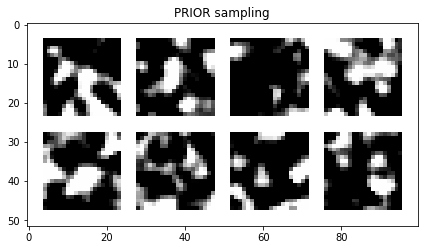

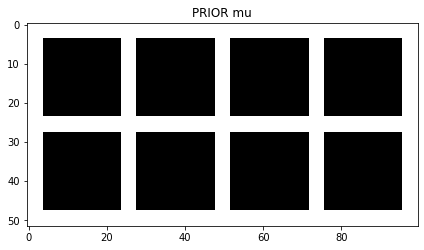

In [81]:
# Create grid
grid = make_mesh_grid(x_array=torch.arange(0,20).float(),
                      y_array=torch.arange(0,20).float())

# Sample prior
batch = 8
mu1 = zero_mean(grid.points)
cov1 = squared_exponential_kernel(grid.points, grid.points, length_scale=2.0)
d_prior = MultivariateNormal(loc=mu1, covariance_matrix=cov1).expand([8])
zprior = d_prior.sample()

print("mu1 --->",mu1.shape, mu1.device)
print("cov1 --->",cov1.shape, cov1.device)
print("zprior ->",zprior.shape, zprior.device)

tmp1 = d_prior.log_prob(zprior)
tmp2 = Normal(loc=zprior, scale=0.05).log_prob(zprior).sum(dim=-1)
tmp3 = Normal(loc=0, scale=1).log_prob(zprior).sum(dim=-1)
print(tmp1,tmp2,tmp3)

# reshape to see the results
prior_z_img = show_batch(zprior.view([batch,1]+list(xv.shape)), n_col=4, n_padding=4, title="PRIOR sampling")
prior_mu_img = show_batch(mu1.expand([8,-1]).view([batch,1]+list(xv.shape)), n_col=4, n_padding=4, title="PRIOR mu")
display(prior_z_img, prior_mu_img)



mu0 ---> torch.Size([8, 400]) cuda:0
sigma0 ---> torch.Size([8, 400]) cuda:0
z_posterior --> torch.Size([8, 400]) cuda:0


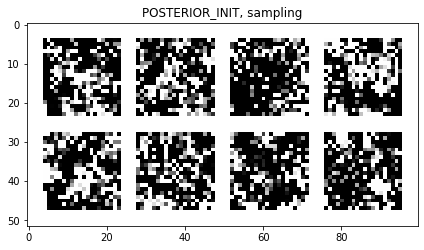

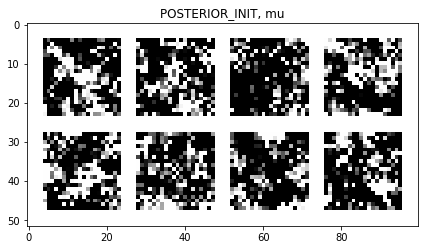

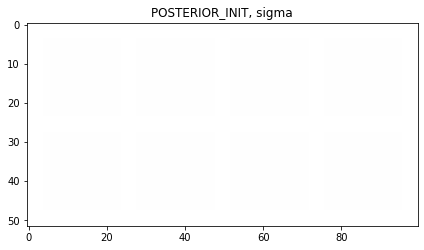

In [95]:
# the posterior is initialized as a small perturbation on top of the prior

sigma0_init = torch.ones_like(zprior).requires_grad_(False)
mu0_init = (zprior + 1.0 * torch.randn_like(zprior)).requires_grad_(False)
zposterior_init = Normal(loc=mu0_init, scale=sigma0_init).sample()

print("mu0 --->",mu0_init.shape, mu0_init.device)
print("sigma0 --->",sigma0_init.shape, sigma0_init.device)
print("z_posterior -->",zposterior_init.shape,zposterior_init.device)

# reshape to see the results
post_z_img_init = show_batch(zposterior_init.view([batch,1]+list(xv.shape)), 
                        n_col=4, n_padding=4, title="POSTERIOR_INIT, sampling")

post_mu_img_init = show_batch(mu0_init.view([batch,1]+list(xv.shape)), 
                         n_col=4, n_padding=4, title="POSTERIOR_INIT, mu")

post_sigma_img_init = show_batch(sigma0_init.view([batch,1]+list(xv.shape)), 
                        n_col=4, n_padding=4, title="POSTERIOR_INIT, sigma")

display(post_z_img_init, post_mu_img_init, post_sigma_img_init)

# Initialize the coarsening

In [96]:
L1_prior = torch.cholesky(cov1)
mu0 = mu0_init.clone().requires_grad_(True) 
sigma0 = sigma0_init.clone().requires_grad_(True) 
optimizer = torch.optim.Adam(params=[mu0, sigma0], lr = 1E-4)
loss_history = []
dir_output = "output_tmp"
# create output directionry if it does nto exists
try:
    os.mkdir(dir_output)
except FileExistsError:
    pass

print(mu0)
print(sigma0)

tensor([[-1.8639,  0.4129, -1.1492,  ...,  1.5047,  0.0890,  0.4722],
        [-0.4112, -0.6066, -1.7663,  ..., -0.0074,  1.9420,  0.0639],
        [-0.0393,  0.4237, -1.2524,  ...,  0.3856,  1.1372, -0.7582],
        ...,
        [-0.6934, -1.4095, -0.9646,  ...,  0.9843, -0.1385,  3.2498],
        [ 0.3403, -1.1114, -2.3971,  ...,  1.8556,  0.9438,  4.0140],
        [-2.1006, -1.5641,  0.0060,  ...,  0.6332, -2.3839, -2.2471]],
       device='cuda:0', requires_grad=True)
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0', requires_grad=True)


# Test differentiability

In [97]:
for epoch in range(100001):
    
    
    kl = KL_multivariate_analytical_smart(mu0=mu0, 
                                          mu1=torch.zeros_like(mu0).detach(), 
                                          L_cov0=torch.diag_embed(sigma0, dim1=-2, dim2=-1), 
                                          L_cov1=L1_prior.detach())
    
    loss = kl.mean()
    loss_history.append(loss.detach().item())
    if epoch % 1000 == 0:
        print(epoch, loss)
        with torch.no_grad():
            if epoch < 10:
                l = '00000'+str(epoch)
            elif epoch < 100:
                l = '0000'+str(epoch)
            elif epoch < 1000:
                l = '000'+str(epoch)
            elif epoch < 10000:
                l = '00'+str(epoch)
            elif epoch < 100000:
                l = '0'+str(epoch)
            elif epoch < 1000000:
                l = str(epoch)
            else:
                raise Exception
                
            z = Normal(loc=mu0, scale=sigma0).sample()
            z_img = show_batch(z.view([batch,1]+list(xv.shape)), n_col=4, n_padding=4, title="z, epoch ="+l)
            mu_img = show_batch(mu0.view([batch,1]+list(xv.shape)), n_col=4, n_padding=4, title="mu, epoch ="+l)
            sigma_img = show_batch(sigma0.view([batch,1]+list(xv.shape)), n_col=4, n_padding=4, title="sigma, epoch ="+l)
            z_img.savefig(os.path.join(dir_output,"movie_z_"+l+".png"))
            mu_img.savefig(os.path.join(dir_output,"movie_mu_"+l+".png"))
            sigma_img.savefig(os.path.join(dir_output,"movie_sigma_"+l+".png"))
        
    optimizer.zero_grad()
    loss.backward()  
    optimizer.step()

0 tensor(210738.0469, device='cuda:0', grad_fn=<MeanBackward0>)
1000 tensor(171250., device='cuda:0', grad_fn=<MeanBackward0>)
2000 tensor(137936.4062, device='cuda:0', grad_fn=<MeanBackward0>)
3000 tensor(109639.7578, device='cuda:0', grad_fn=<MeanBackward0>)
4000 tensor(85625.7969, device='cuda:0', grad_fn=<MeanBackward0>)
5000 tensor(65407.2539, device='cuda:0', grad_fn=<MeanBackward0>)
6000 tensor(48635.8672, device='cuda:0', grad_fn=<MeanBackward0>)
7000 tensor(35029.6055, device='cuda:0', grad_fn=<MeanBackward0>)
8000 tensor(24325.1875, device='cuda:0', grad_fn=<MeanBackward0>)
9000 tensor(16252.4580, device='cuda:0', grad_fn=<MeanBackward0>)
10000 tensor(10512.4404, device='cuda:0', grad_fn=<MeanBackward0>)
11000 tensor(6751.0713, device='cuda:0', grad_fn=<MeanBackward0>)
12000 tensor(4512.1694, device='cuda:0', grad_fn=<MeanBackward0>)
13000 tensor(3182.6626, device='cuda:0', grad_fn=<MeanBackward0>)
14000 tensor(2291.2661, device='cuda:0', grad_fn=<MeanBackward0>)
15000 tensor

KeyboardInterrupt: 

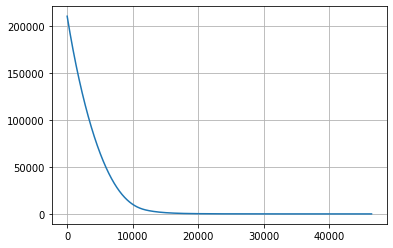

In [98]:
plt.plot(loss_history,label="loss")
plt.grid()

In [99]:
print(mu0_init[0].shape, mu0_init[0,:20])
print(mu0[0].shape, mu0[0,:20])
print(sigma0_init[0].shape, sigma0_init[0,:20])
print(sigma0[0].shape, sigma0[0,:20])
print(zprior.shape, zprior[0,:20])
print(zprior.shape, zprior[0,:20])

torch.Size([400]) tensor([-1.8639,  0.4129, -1.1492, -2.2910, -1.4881, -1.7774, -1.8087,  0.5238,
        -1.8871,  0.2562, -2.2659, -3.9682, -1.8900, -0.5745,  0.4274,  0.5564,
        -0.3806, -0.4516, -0.8706,  0.0304], device='cuda:0')
torch.Size([400]) tensor([ 0.0315,  0.0420,  0.0452,  0.0382,  0.0236,  0.0060, -0.0145, -0.0464,
        -0.1016, -0.1803, -0.2571, -0.2910, -0.2595, -0.1831, -0.1030, -0.0471,
        -0.0183, -0.0067, -0.0026, -0.0012], device='cuda:0',
       grad_fn=<SliceBackward>)
torch.Size([400]) tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], device='cuda:0')
torch.Size([400]) tensor([0.1155, 0.0648, 0.0535, 0.0511, 0.0507, 0.0505, 0.0504, 0.0503, 0.0503,
        0.0503, 0.0503, 0.0503, 0.0503, 0.0504, 0.0505, 0.0507, 0.0511, 0.0535,
        0.0648, 0.1155], device='cuda:0', grad_fn=<SliceBackward>)
torch.Size([8, 400]) tensor([-1.0613, -0.8160, -0.7917, -0.7724, -1.0253, -1.2130, -1.2625, -0.8038,
        -0

# MAKE THE MOVIE

In [100]:
movie_z_filenames = glob.glob(dir_output+"/movie_z_*.png")
movie_mu_filenames = glob.glob(dir_output+"/movie_mu_*.png")
movie_sigma_filenames = glob.glob(dir_output+"/movie_sigma_*.png")
       
movie_z_filenames.sort()
movie_mu_filenames.sort()
movie_sigma_filenames.sort()

print(movie_z_filenames)
print(movie_mu_filenames)
print(movie_sigma_filenames)

['output_tmp/movie_z_000000.png', 'output_tmp/movie_z_001000.png', 'output_tmp/movie_z_002000.png', 'output_tmp/movie_z_003000.png', 'output_tmp/movie_z_004000.png', 'output_tmp/movie_z_005000.png', 'output_tmp/movie_z_006000.png', 'output_tmp/movie_z_007000.png', 'output_tmp/movie_z_008000.png', 'output_tmp/movie_z_009000.png', 'output_tmp/movie_z_010000.png', 'output_tmp/movie_z_011000.png', 'output_tmp/movie_z_012000.png', 'output_tmp/movie_z_013000.png', 'output_tmp/movie_z_014000.png', 'output_tmp/movie_z_015000.png', 'output_tmp/movie_z_016000.png', 'output_tmp/movie_z_017000.png', 'output_tmp/movie_z_018000.png', 'output_tmp/movie_z_019000.png', 'output_tmp/movie_z_020000.png', 'output_tmp/movie_z_021000.png', 'output_tmp/movie_z_022000.png', 'output_tmp/movie_z_023000.png', 'output_tmp/movie_z_024000.png', 'output_tmp/movie_z_025000.png', 'output_tmp/movie_z_026000.png', 'output_tmp/movie_z_027000.png', 'output_tmp/movie_z_028000.png', 'output_tmp/movie_z_029000.png', 'output_t

In [101]:
def show_frame_z(n):
    return Image(filename=movie_z_filenames[n])

def show_frame_mu(n):
    return Image(filename=movie_mu_filenames[n])

def show_frame_sigma(n):
    return Image(filename=movie_sigma_filenames[n])

def show_frame_all(n):
    try:
        a = Image(filename=movie_z_filenames[n])
        b = Image(filename=movie_mu_filename[n])
        c = Image(filename=movie_sigma_filenames[n])
        return display(a,b,c)
    except IndexError:
        print("list index out of range")
        pass

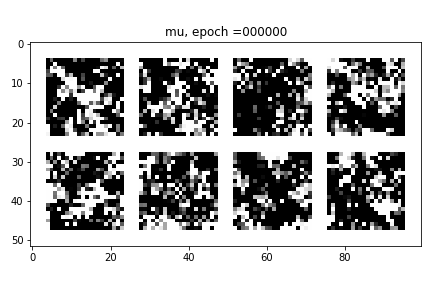

In [102]:
a=show_frame_mu(0)
display(a)
#b=show_frame_mu(50)
#c=show_frame_mu(100)
#display(a,b,c)

In [103]:
a=show_frame_sigma(0)
b=show_frame_sigma(50)
c=show_frame_sigma(100)
display(a,b,c)

IndexError: list index out of range

In [104]:
a=show_frame_z(0)
b=show_frame_z(50)
c=show_frame_z(100)
display(a,b,c)

IndexError: list index out of range

In [105]:
movie_z_name = "movie_z.gif"
movie_mu_name = "movie_mu.gif"
movie_sigma_name = "movie_sigma.gif"

frame_per_second = 10

im = mpy.ImageSequenceClip(movie_z_filenames, fps=frame_per_second)
im.write_gif(movie_z_name, fps=frame_per_second)

im = mpy.ImageSequenceClip(movie_mu_filenames, fps=frame_per_second)
im.write_gif(movie_mu_name, fps=frame_per_second)

im = mpy.ImageSequenceClip(movie_sigma_filenames, fps=frame_per_second)
im.write_gif(movie_sigma_name, fps=frame_per_second)

t:  13%|█▎        | 6/47 [00:00<00:00, 58.94it/s, now=None]

MoviePy - Building file movie_z.gif with imageio.


t:  15%|█▍        | 7/47 [00:00<00:00, 59.99it/s, now=None] 

MoviePy - Building file movie_mu.gif with imageio.


t:  15%|█▍        | 7/47 [00:00<00:00, 65.33it/s, now=None] 

MoviePy - Building file movie_sigma.gif with imageio.


In [106]:
HTML("<img src="+movie_z_name+"></img>")

In [107]:
HTML("<img src="+movie_mu_name+"></img>")

In [108]:
HTML("<img src="+movie_sigma_name+"></img>")